## Kaggle Competition: Aerial Cactus Identification

##### Team member: Qiang Wang, Xinrong Chen, Sherly Zhang

In [1]:
import pandas as pd
import os,cv2
from IPython.display import Image
from keras import layers, models
from keras.layers import Dense, Dropout, Flatten
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier
import numpy as np
import tensorflow as tf
import keras 
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense
import numpy as np
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.utils import to_categorical

/Users/wangqiang/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
dir = os.getcwd()

In [3]:
train = pd.read_csv(dir+'/train.csv')
test = pd.read_csv(dir+'/sample_submission.csv')
train2 = train.sort_values(by=['id'])

### Data Description

In [4]:
train.describe()

,has_cactus
count,17500.000000
mean,0.750629
std,0.432662
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


In [5]:
test.describe()

,has_cactus
count,4000.0
mean,0.5
std,0.0
min,0.5
25%,0.5
50%,0.5
75%,0.5
max,0.5


Since the column: has_cactus is numeric by default, should be changed to binomial that 1 denotes have cactus, 0 denotes do not have cactus

In [6]:
train['has_cactus']=train['has_cactus'].astype(str)

In [7]:
train.describe()

,id,has_cactus
count,17500,17500
unique,17500,2
top,5664f5f913557cdaae499ca74d5495da.jpg,1
freq,1,13136


In [8]:
print('The dataset has {} rows and {} columns'.format(train.shape[0],train.shape[1]))

The dataset has 17500 rows and 2 columns


### Image in Dataset

Text(0.5,0.98,'First 16 images in Train Set ')

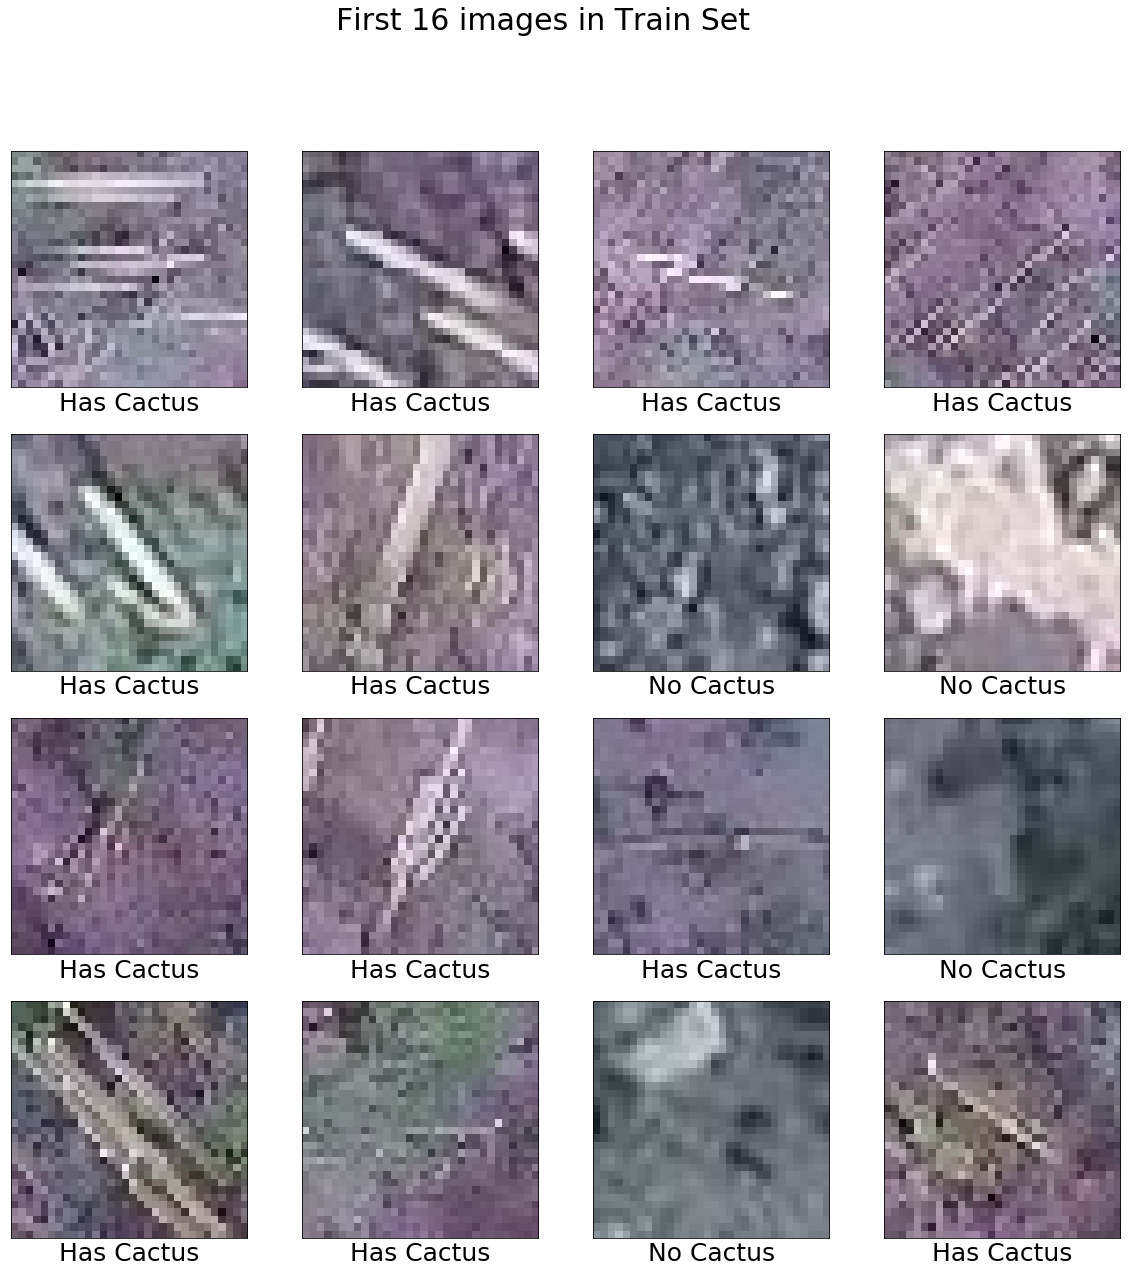

In [9]:
fig=plt.figure(figsize=(20,20))
for i in range(16):
    fig.add_subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    if train.iloc[i,1]=="1":
        l="Has Cactus"
    elif train.iloc[i,1]=="0":
        l="No Cactus"
    plt.xlabel(l,fontsize=25)
    im = cv2.imread(dir+'/train/{}'.format(train.iloc[i,0]))
    plt.imshow(im)
plt.suptitle("First 16 images in Train Set ",fontsize=30)

### Import Image to Data type

We looked into some kernels in Kaggle for reference. They gave the process listed below.

(Quoted from Shahules786's kernel: 'Getting started with CNN and VGG16')

* Read the picture files
* Decode JPEG content to RGB pixels
* Convert this into floating tensors
* Rescale pixel values (between 0 to 255) to [0,1] interval.

(Quoted from Shahules786's kernel: 'Getting started with CNN and VGG16')

#### tqdm
This method is useful when the images are clustered in only one folder. To put in other words images from different class/labels reside in only one folder. Generally, with such kind of data, some text files containing information on class and other parameters are provided. In this case, we will create a dataframe using pandas and text files provided, and create a meaningful dataframe with columns having file name(only the file names, not the path) and other classes to be used by the model. 

In [10]:
id=train2['id'].values
l=train2['has_cactus'].values

train3=[]
X=[]
Y=[]
a=0

for i in tqdm(sorted(os.listdir(dir+"/train/"))):
    p=os.path.join(dir+"/train/",i)
    i=cv2.imread(p,cv2.IMREAD_COLOR)
    X.append(i)
    train3.append([np.array(i),l[a]])
    a=a+1

train3=np.array(train3)
Y=train3[:,1]
train3=train3[:,0]
X=np.array(X)

X.shape

100%|██████████| 17500/17500 [00:09<00:00, 1793.22it/s]


(17500, 32, 32, 3)

In [11]:
### rescale the train data
X = X/255
train3 = train3/255

In [12]:
### prepare the set for test
test2=[]
X_test=[]

for i in tqdm(sorted(os.listdir(dir+"/test/"))):
    p=os.path.join(dir+"/test/",i)
    i=cv2.imread(p,cv2.IMREAD_COLOR)   ### read in the images
    X_test.append(i)
    test2.append([np.array(i),id])

X_test=np.array(X_test)
X_test.shape
test2=np.array(test2)
id_test=test2[:,1]
test2=test2[:,0]
test2.shape
           

100%|██████████| 4000/4000 [00:02<00:00, 1885.95it/s]


(4000,)

In [13]:
X_test = X_test/255
test2 = test2/255

### Build Convolutional Neural Network Model (with Keras)

#### Try different parameters

* Optimizer(rmsprop, adam, SGD)

In [14]:
def cnn_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32,(2,2),activation='relu',input_shape=(32,32,3)))
    model.add(layers.MaxPool2D((2,2)))
    model.add(Dropout(0.2))
    model.add(layers.Conv2D(64,(2,2),activation='relu'))
    model.add(layers.MaxPool2D((2,2)))
    model.add(Dropout(0.2))
    model.add(layers.Conv2D(64,(2,2),activation='relu'))
    model.add(layers.MaxPool2D((2,2)))
    model.add(Dropout(0.2))
    model.add(layers.Flatten())
    model.add(layers.Dense(128,activation='relu'))
    model.add(Dropout(0.5))
    model.add(layers.Dense(1,activation='sigmoid'))
    return model

* RMSPROP

In [15]:
model_rmsprop = cnn_model()

W0628 03:41:36.030930 140735983256448 deprecation_wrapper.py:119] From /Users/wangqiang/anaconda3/lib/python3.6/site-packages/Keras-2.2.4-py3.6.egg/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0628 03:41:36.068181 140735983256448 deprecation_wrapper.py:119] From /Users/wangqiang/anaconda3/lib/python3.6/site-packages/Keras-2.2.4-py3.6.egg/keras/backend/tensorflow_backend.py:529: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0628 03:41:36.072583 140735983256448 deprecation_wrapper.py:119] From /Users/wangqiang/anaconda3/lib/python3.6/site-packages/Keras-2.2.4-py3.6.egg/keras/backend/tensorflow_backend.py:4420: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0628 03:41:36.120580 140735983256448 deprecation_wrapper.py:119] From /Users/wangqiang/anaconda3/lib/python3.6/site-packages/Keras-2.2.4-py3.6.egg/keras/backend/tensorfl

In [16]:
model_rmsprop.compile(loss='binary_crossentropy',optimizer=optimizers.rmsprop(),metrics=['acc'])

W0628 03:41:36.385902 140735983256448 deprecation_wrapper.py:119] From /Users/wangqiang/anaconda3/lib/python3.6/site-packages/Keras-2.2.4-py3.6.egg/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0628 03:41:36.396764 140735983256448 deprecation_wrapper.py:119] From /Users/wangqiang/anaconda3/lib/python3.6/site-packages/Keras-2.2.4-py3.6.egg/keras/backend/tensorflow_backend.py:3645: The name tf.log is deprecated. Please use tf.math.log instead.

W0628 03:41:36.405514 140735983256448 deprecation.py:323] From /Users/wangqiang/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [17]:
history=model_rmsprop.fit(X, Y, batch_size = 250,validation_split = 0.2, epochs = 30)

Train on 14000 samples, validate on 3500 samples
Epoch 1/30
14000/14000 [==============================] - 14s 996us/step - loss: 0.4384 - acc: 0.7854 - val_loss: 0.2939 - val_acc: 0.9266
Epoch 2/30
14000/14000 [==============================] - 15s 1ms/step - loss: 0.2578 - acc: 0.9058 - val_loss: 0.3731 - val_acc: 0.8186
Epoch 3/30
14000/14000 [==============================] - 14s 1ms/step - loss: 0.2135 - acc: 0.9182 - val_loss: 0.1755 - val_acc: 0.9400
Epoch 4/30
14000/14000 [==============================] - 15s 1ms/step - loss: 0.1920 - acc: 0.9286 - val_loss: 0.2763 - val_acc: 0.8834
Epoch 5/30
14000/14000 [==============================] - 14s 1000us/step - loss: 0.1759 - acc: 0.9325 - val_loss: 0.1523 - val_acc: 0.9437
Epoch 6/30
14000/14000 [==============================] - 13s 942us/step - loss: 0.1593 - acc: 0.9422 - val_loss: 0.2344 - val_acc: 0.9040
Epoch 7/30
14000/14000 [==============================] - 15s 1ms/step - loss: 0.1426 - acc: 0.9461 - val_loss: 0.1139 - v

In [18]:
pred=model_rmsprop.predict(X_test)
ids=[]
label=[]
a=0
for i in tqdm(sorted(os.listdir(dir+"/test/"))):
    id=i
    ids.append(id)
    label.append(pred[a])
    a=a+1

label=np.array(label,dtype='float64')
out=pd.DataFrame({'id': ids,'has_cactus':label[:,0]})
out = pd.concat([out.id,out.has_cactus],axis = 1)
out.to_csv('test_rmsprop.csv',index=False,header=True)

100%|██████████| 4000/4000 [00:00<00:00, 363639.07it/s]


* ADAM

In [19]:
model_adam = cnn_model()

In [20]:
model_adam.compile(loss='binary_crossentropy',optimizer="adam",metrics=['acc'])

In [21]:
history=model_adam.fit(X, Y, batch_size = 250,validation_split = 0.2, epochs = 30)

Train on 14000 samples, validate on 3500 samples
Epoch 1/30
14000/14000 [==============================] - 15s 1ms/step - loss: 0.3936 - acc: 0.8144 - val_loss: 0.1973 - val_acc: 0.9249
Epoch 2/30
14000/14000 [==============================] - 14s 1ms/step - loss: 0.1852 - acc: 0.9295 - val_loss: 0.2041 - val_acc: 0.9143
Epoch 3/30
14000/14000 [==============================] - 13s 907us/step - loss: 0.1596 - acc: 0.9406 - val_loss: 0.1426 - val_acc: 0.9443
Epoch 4/30
14000/14000 [==============================] - 14s 1ms/step - loss: 0.1483 - acc: 0.9429 - val_loss: 0.1434 - val_acc: 0.9457
Epoch 5/30
14000/14000 [==============================] - 19s 1ms/step - loss: 0.1368 - acc: 0.9483 - val_loss: 0.1429 - val_acc: 0.9457
Epoch 6/30
14000/14000 [==============================] - 17s 1ms/step - loss: 0.1195 - acc: 0.9543 - val_loss: 0.1147 - val_acc: 0.9571
Epoch 7/30
14000/14000 [==============================] - 16s 1ms/step - loss: 0.1076 - acc: 0.9596 - val_loss: 0.1017 - val_ac

In [22]:
pred=model_adam.predict(X_test)
ids=[]
label=[]
a=0
for i in tqdm(sorted(os.listdir(dir+"/test/"))):
    id=i
    ids.append(id)
    label.append(pred[a])
    a=a+1

label=np.array(label,dtype='float64')
out=pd.DataFrame({'id': ids,'has_cactus':label[:,0]})
out = pd.concat([out.id,out.has_cactus],axis = 1)
out.to_csv('test_adam.csv',index=False,header=True)

100%|██████████| 4000/4000 [00:00<00:00, 735681.47it/s]


* SGD

In [23]:
model_sgd = cnn_model()

In [24]:
model_sgd.compile(loss='binary_crossentropy',optimizer='sgd',metrics=['acc'])

In [26]:
history=model_sgd.fit(X, Y, batch_size = 250,validation_split = 0.2, epochs = 30)

Train on 14000 samples, validate on 3500 samples
Epoch 1/30
14000/14000 [==============================] - 16s 1ms/step - loss: 0.5850 - acc: 0.7310 - val_loss: 0.5638 - val_acc: 0.7491
Epoch 2/30
14000/14000 [==============================] - 15s 1ms/step - loss: 0.5609 - acc: 0.7509 - val_loss: 0.5582 - val_acc: 0.7491
Epoch 3/30
14000/14000 [==============================] - 13s 896us/step - loss: 0.5540 - acc: 0.7510 - val_loss: 0.5594 - val_acc: 0.7491
Epoch 4/30
14000/14000 [==============================] - 13s 938us/step - loss: 0.5492 - acc: 0.7511 - val_loss: 0.5536 - val_acc: 0.7491
Epoch 5/30
14000/14000 [==============================] - 11s 788us/step - loss: 0.5438 - acc: 0.7510 - val_loss: 0.5525 - val_acc: 0.7491
Epoch 6/30
14000/14000 [==============================] - 11s 807us/step - loss: 0.5381 - acc: 0.7510 - val_loss: 0.5453 - val_acc: 0.7491
Epoch 7/30
14000/14000 [==============================] - 11s 788us/step - loss: 0.5327 - acc: 0.7510 - val_loss: 0.5355 

In [27]:
pred=model_sgd.predict(X_test)
ids=[]
label=[]
a=0
for i in tqdm(sorted(os.listdir(dir+"/test/"))):
    id=i
    ids.append(id)
    label.append(pred[a])
    a=a+1

label=np.array(label,dtype='float64')
out=pd.DataFrame({'id': ids,'has_cactus':label[:,0]})
out = pd.concat([out.id,out.has_cactus],axis = 1)
out.to_csv('test_sgd.csv',index=False,header=True)

100%|██████████| 4000/4000 [00:00<00:00, 851203.25it/s]


* Adamax

In [28]:
model_adamax = cnn_model()

In [29]:
model_adamax.compile(loss='binary_crossentropy',optimizer='Adamax',metrics=['acc'])

In [30]:
history=model_adamax.fit(X, Y, batch_size = 250,validation_split = 0.2, epochs = 30)

Train on 14000 samples, validate on 3500 samples
Epoch 1/30
14000/14000 [==============================] - 13s 914us/step - loss: 0.4218 - acc: 0.7786 - val_loss: 0.2968 - val_acc: 0.9174
Epoch 2/30
14000/14000 [==============================] - 13s 898us/step - loss: 0.1969 - acc: 0.9318 - val_loss: 0.1937 - val_acc: 0.9214
Epoch 3/30
14000/14000 [==============================] - 13s 903us/step - loss: 0.1717 - acc: 0.9357 - val_loss: 0.1743 - val_acc: 0.9317
Epoch 4/30
14000/14000 [==============================] - 15s 1ms/step - loss: 0.1571 - acc: 0.9416 - val_loss: 0.1765 - val_acc: 0.9294
Epoch 5/30
14000/14000 [==============================] - 16s 1ms/step - loss: 0.1481 - acc: 0.9449 - val_loss: 0.1801 - val_acc: 0.9289
Epoch 6/30
14000/14000 [==============================] - 17s 1ms/step - loss: 0.1386 - acc: 0.9489 - val_loss: 0.1399 - val_acc: 0.9443
Epoch 7/30
14000/14000 [==============================] - 21s 1ms/step - loss: 0.1260 - acc: 0.9522 - val_loss: 0.1073 - va

In [31]:
pred=model_adamax.predict(X_test)
ids=[]
label=[]
a=0
for i in tqdm(sorted(os.listdir(dir+"/test/"))):
    id=i
    ids.append(id)
    label.append(pred[a])
    a=a+1

label=np.array(label,dtype='float64')
out=pd.DataFrame({'id': ids,'has_cactus':label[:,0]})
out = pd.concat([out.id,out.has_cactus],axis = 1)
out.to_csv('test_adamax.csv',index=False,header=True)

100%|██████████| 4000/4000 [00:00<00:00, 729539.33it/s]


* Adagrad

In [32]:
model_adagrad = cnn_model()
model_adagrad.compile(loss='binary_crossentropy',optimizer='Adagrad',metrics=['acc'])
history=model_adagrad.fit(X, Y, batch_size = 250,validation_split = 0.2, epochs = 30)

Train on 14000 samples, validate on 3500 samples
Epoch 1/30
14000/14000 [==============================] - 17s 1ms/step - loss: 0.4497 - acc: 0.7899 - val_loss: 0.2399 - val_acc: 0.9226
Epoch 2/30
14000/14000 [==============================] - 14s 974us/step - loss: 0.2103 - acc: 0.9212 - val_loss: 0.1983 - val_acc: 0.9249
Epoch 3/30
14000/14000 [==============================] - 17s 1ms/step - loss: 0.1718 - acc: 0.9335 - val_loss: 0.1538 - val_acc: 0.9383
Epoch 4/30
14000/14000 [==============================] - 19s 1ms/step - loss: 0.1651 - acc: 0.9356 - val_loss: 0.1772 - val_acc: 0.9289
Epoch 5/30
14000/14000 [==============================] - 16s 1ms/step - loss: 0.1541 - acc: 0.9416 - val_loss: 0.1624 - val_acc: 0.9351
Epoch 6/30
14000/14000 [==============================] - 19s 1ms/step - loss: 0.1450 - acc: 0.9451 - val_loss: 0.1352 - val_acc: 0.9477
Epoch 7/30
14000/14000 [==============================] - 18s 1ms/step - loss: 0.1395 - acc: 0.9459 - val_loss: 0.1234 - val_ac

In [33]:
pred=model_adagrad.predict(X_test)
ids=[]
label=[]
a=0
for i in tqdm(sorted(os.listdir(dir+"/test/"))):
    id=i
    ids.append(id)
    label.append(pred[a])
    a=a+1

label=np.array(label,dtype='float64')
out=pd.DataFrame({'id': ids,'has_cactus':label[:,0]})
out = pd.concat([out.id,out.has_cactus],axis = 1)
out.to_csv('test_adagrad.csv',index=False,header=True)

100%|██████████| 4000/4000 [00:00<00:00, 528249.87it/s]


* Adadelta

In [34]:
model_adadelta = cnn_model()
model_adadelta.compile(loss='binary_crossentropy',optimizer='Adadelta',metrics=['acc'])
history=model_adadelta.fit(X, Y, batch_size = 250,validation_split = 0.2, epochs = 30)

Train on 14000 samples, validate on 3500 samples
Epoch 1/30
14000/14000 [==============================] - 18s 1ms/step - loss: 0.5224 - acc: 0.7496 - val_loss: 0.5129 - val_acc: 0.7491
Epoch 2/30
14000/14000 [==============================] - 14s 1ms/step - loss: 0.3561 - acc: 0.8496 - val_loss: 0.2691 - val_acc: 0.9040
Epoch 3/30
14000/14000 [==============================] - 16s 1ms/step - loss: 0.2846 - acc: 0.8905 - val_loss: 0.2207 - val_acc: 0.9209
Epoch 4/30
14000/14000 [==============================] - 15s 1ms/step - loss: 0.2459 - acc: 0.9064 - val_loss: 0.1999 - val_acc: 0.9237
Epoch 5/30
14000/14000 [==============================] - 15s 1ms/step - loss: 0.1931 - acc: 0.9273 - val_loss: 0.2254 - val_acc: 0.9077
Epoch 6/30
14000/14000 [==============================] - 24s 2ms/step - loss: 0.1881 - acc: 0.9276 - val_loss: 0.1818 - val_acc: 0.9263
Epoch 7/30
14000/14000 [==============================] - 17s 1ms/step - loss: 0.1749 - acc: 0.9344 - val_loss: 0.1517 - val_acc:

In [35]:
pred=model_adadelta.predict(X_test)
ids=[]
label=[]
a=0
for i in tqdm(sorted(os.listdir(dir+"/test/"))):
    id=i
    ids.append(id)
    label.append(pred[a])
    a=a+1

label=np.array(label,dtype='float64')
out=pd.DataFrame({'id': ids,'has_cactus':label[:,0]})
out = pd.concat([out.id,out.has_cactus],axis = 1)
out.to_csv('test_adadelta.csv',index=False,header=True)

100%|██████████| 4000/4000 [00:00<00:00, 639473.09it/s]


* Nadam

In [36]:
model_nadam = cnn_model()
model_nadam.compile(loss='binary_crossentropy',optimizer='Nadam',metrics=['acc'])
history=model_nadam.fit(X, Y, batch_size = 250,validation_split = 0.2, epochs = 30)

Train on 14000 samples, validate on 3500 samples
Epoch 1/30
14000/14000 [==============================] - 13s 897us/step - loss: 0.3710 - acc: 0.8325 - val_loss: 0.4557 - val_acc: 0.8260
Epoch 2/30
14000/14000 [==============================] - 11s 812us/step - loss: 0.1914 - acc: 0.9290 - val_loss: 0.1649 - val_acc: 0.9391
Epoch 3/30
14000/14000 [==============================] - 11s 812us/step - loss: 0.1668 - acc: 0.9389 - val_loss: 0.1439 - val_acc: 0.9417
Epoch 4/30
14000/14000 [==============================] - 11s 820us/step - loss: 0.1545 - acc: 0.9425 - val_loss: 0.1414 - val_acc: 0.9437
Epoch 5/30
14000/14000 [==============================] - 11s 815us/step - loss: 0.1386 - acc: 0.9473 - val_loss: 0.2695 - val_acc: 0.8711
Epoch 6/30
14000/14000 [==============================] - 12s 830us/step - loss: 0.1337 - acc: 0.9473 - val_loss: 0.1052 - val_acc: 0.9589
Epoch 7/30
14000/14000 [==============================] - 11s 818us/step - loss: 0.1193 - acc: 0.9545 - val_loss: 0.0

In [37]:
pred=model_nadam.predict(X_test)
ids=[]
label=[]
a=0
for i in tqdm(sorted(os.listdir(dir+"/test/"))):
    id=i
    ids.append(id)
    label.append(pred[a])
    a=a+1

label=np.array(label,dtype='float64')
out=pd.DataFrame({'id': ids,'has_cactus':label[:,0]})
out = pd.concat([out.id,out.has_cactus],axis = 1)
out.to_csv('test_nadam.csv',index=False,header=True)

100%|██████████| 4000/4000 [00:00<00:00, 625105.85it/s]


### Kaggle Score (measured by area under the ROC curve)

* RMSPROP

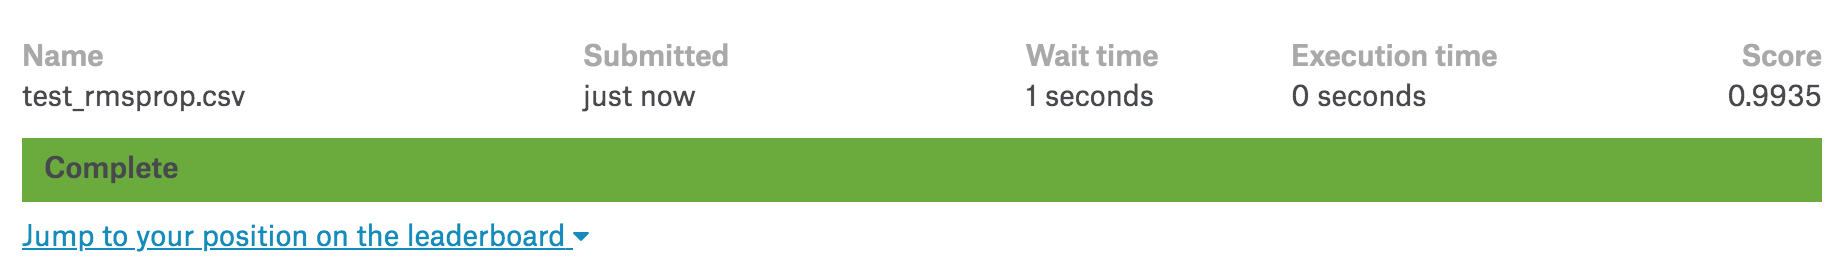

In [47]:
Image(os.path.join(dir,'rmsprop_score.png'))

* Adam

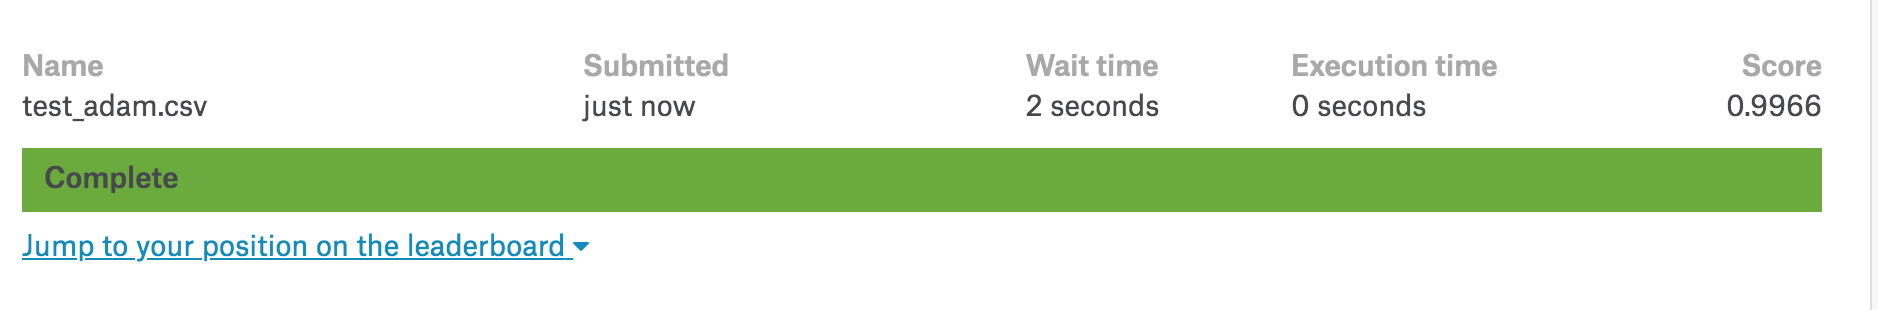

In [44]:
Image(os.path.join(dir,'adam_score.png'))

* SGD

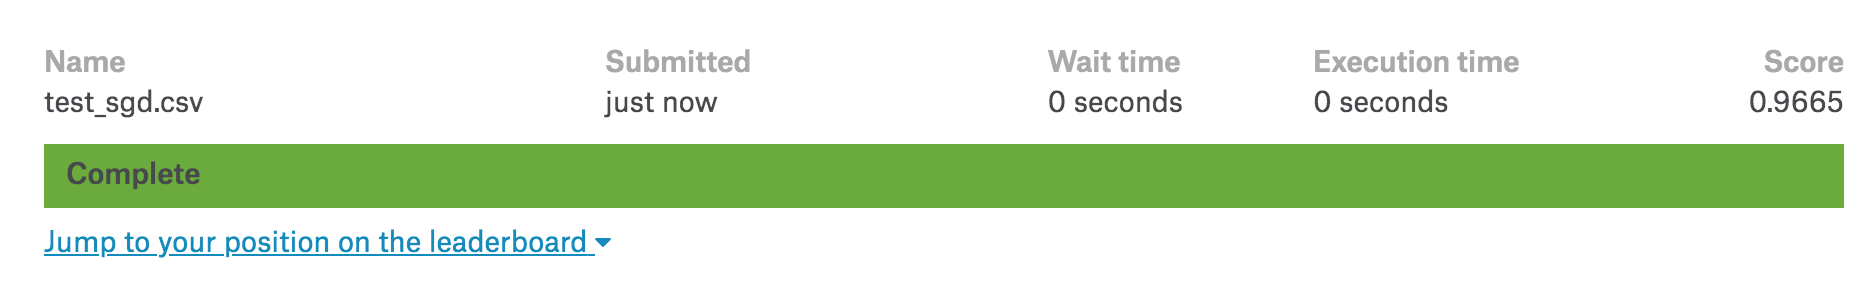

In [48]:
Image(os.path.join(dir,'sgd_score.png'))

* Adamax

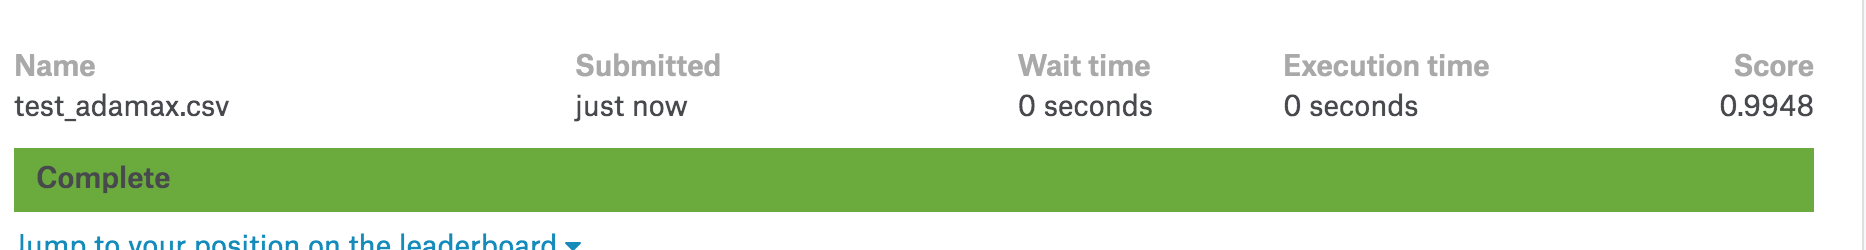

In [45]:
Image(os.path.join(dir,'adamax_score.png'))

* Adagrad

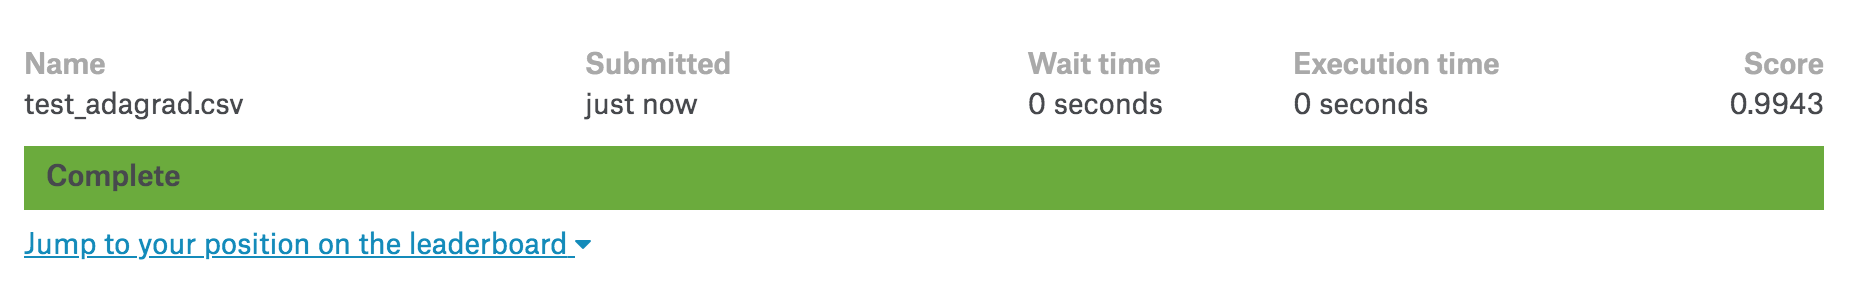

In [43]:
Image(os.path.join(dir,'adagrad_score.png'))

* Adadelta

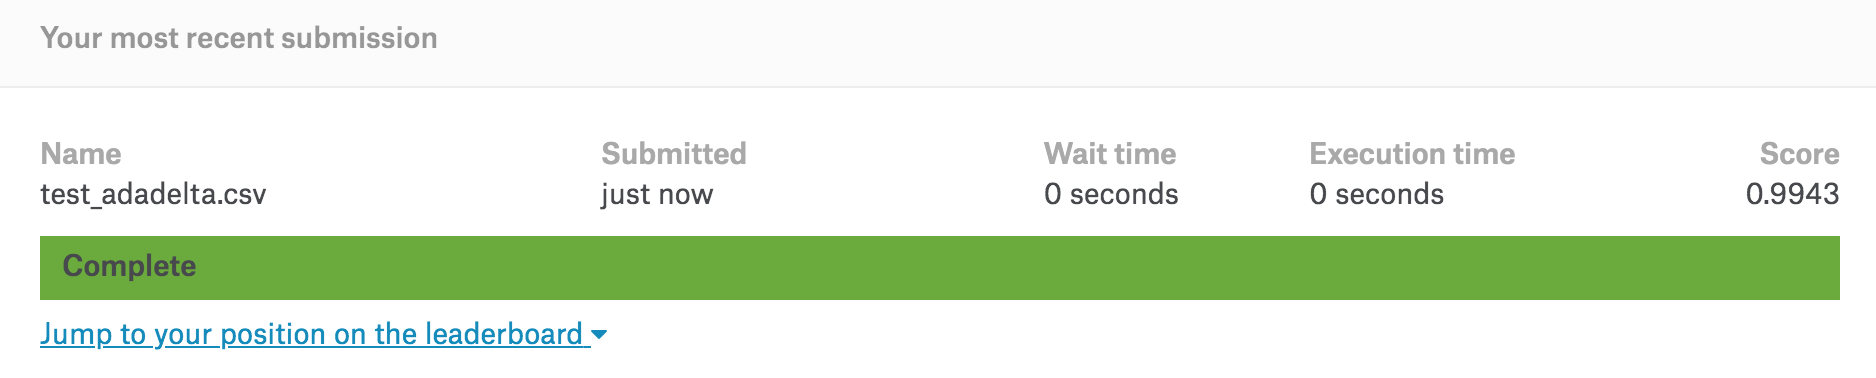

In [42]:
Image(os.path.join(dir,'adadelta_score.png'))

* Nadam

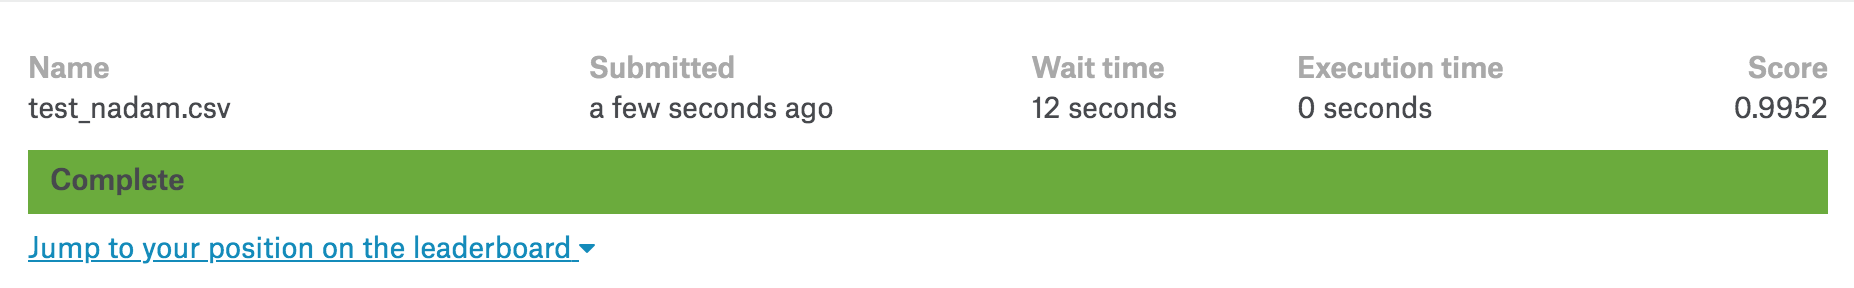

In [46]:
Image(os.path.join(dir,'nadam_score.png'))

In sum, 'adam' is the best optimizer and 'sgd' is the worst, the highest overall score of the competition is 0.9966.